In [135]:
print("Hello World!")

Hello World!


In [156]:
from tinygrad.core import Tensor
import tinygrad.nn as nn
import tinygrad.optimizers as optim
from tinygrad.losses import *

import matplotlib.pyplot as plt
import numpy as np
import csv
import math
import time
import tqdm
import random

In [137]:
path = "sonar.all-data"

In [138]:
dataset = []
with open(path, "rt") as fp:
    data = csv.reader(fp, delimiter=",")
    for row in data:
        dataset.append(row)

string2float = lambda x: list(map(float, x))

classes = ["R", "M"]

dataset = [[string2float(x[:59]), classes.index(x[60])] for x in dataset]

print("Total length of dataset: ", len(dataset))

Total length of dataset:  208


In [139]:
tensorify = lambda x: list(map(Tensor, x))

def check_class_balance(dataset):

    count = [0, 0]
    for x in dataset:
        count[x[1]] += 1
    print("R:{} M:{}".format(count[0], count[1]))
    plt.bar(["R", "M"], count)
    plt.show()

R:97 M:111


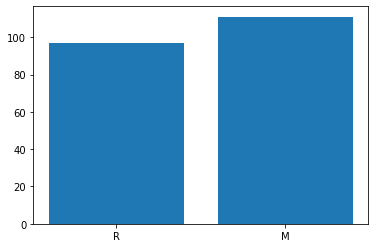

In [140]:
check_class_balance(dataset)

In [141]:
rock_percent = 0.46
train_percent = .90

train_rock_num = round(train_percent * 97)
train_mine_num = round(train_percent * 111)
rock_last_idx = round(rock_percent * len(dataset))

train_ids = [random.sample(range(x, y), k=z) for (x, y), z in zip([(0, rock_last_idx+1), (rock_last_idx+1, 208)],\
                                                               [train_rock_num, train_mine_num])]
train_ids = [item for sublist in train_ids for item in sublist]

trainset = [dataset[x] for x in train_ids]
testset = [x for x in dataset if x not in trainset]

random.shuffle(trainset)
random.shuffle(testset)

print("Len of trainset: ", len(trainset))
print("Len of testset: ", len(testset))

Len of trainset:  187
Len of testset:  21


R:87 M:100


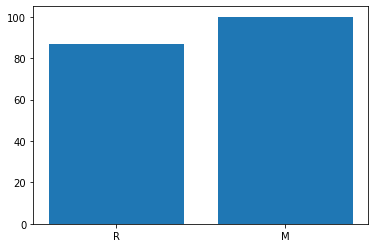

R:10 M:11


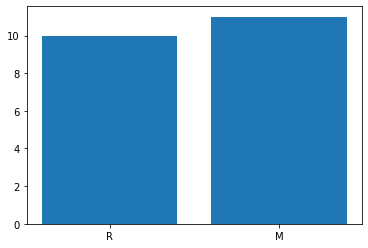

In [142]:
check_class_balance(trainset)
check_class_balance(testset)

In [143]:
trainset = [[tensorify(x[0]), Tensor(x[1])] for x in trainset]
testset = [[tensorify(x[0]), Tensor(x[1])] for x in testset]

In [201]:
# we dont define any dataloader because the dataset is anyway small ;)
# we define our model here

model = nn.SimpleMLP(60, 1, [12])

# temporary fix to make last layer nonlin=False
for i, layer in enumerate(model.layers):
    if i == len(model.layers) - 1:
        for n in layer.neurons:
            n.nonlin = False

model.summary()
print("Number of parameters: ", len(model.parameters()))

SimpleMLP(
Linear(ins:60 outs:12 num_parameters:732)
Linear(ins:12 outs:1 num_parameters:13)
)
Number of parameters:  745


In [202]:
# here we define the other parameters, optimizers and loss functions
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = SmoothL1Loss

epochs = 100

In [203]:
# finally our training loop! 
losslist = []

start_time = time.time()
for epoch in range(epochs):
    
    running_loss = 0
    epoch_start = time.time()
    for data in  trainset:
        
        xi, yi = data[0], data[1]
        
        preds = model(xi)
        
        loss = loss_fn(preds, yi)
        
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data
    
    epoch_end = time.time()
    running_loss /= len(trainset)
    losslist.append(running_loss)
    
    if epoch%1 == 0:
        print("Epoch #{}, Loss: {}, time taken:{}".format(epoch, running_loss, epoch_end-epoch_start))

print("Total time taken: ", time.time()-start_time)
    


Epoch #0, Loss: 0.3661788782000029, time taken:3.6920783519744873
Epoch #1, Loss: 0.22026149908575782, time taken:3.6208980083465576
Epoch #2, Loss: 0.17753435597052708, time taken:4.312457084655762
Epoch #3, Loss: 0.1531621402789071, time taken:5.387780427932739
Epoch #4, Loss: 0.13794527591740607, time taken:5.029521942138672
Epoch #5, Loss: 0.12709482324628613, time taken:5.93364953994751
Epoch #6, Loss: 0.11901734191474642, time taken:5.05040979385376
Epoch #7, Loss: 0.1126475707557349, time taken:6.631456613540649
Epoch #8, Loss: 0.1075377024662288, time taken:8.083942413330078
Epoch #9, Loss: 0.10281310594235207, time taken:7.755906105041504
Epoch #10, Loss: 0.09875506901451099, time taken:4.706064939498901
Epoch #11, Loss: 0.09562347418491367, time taken:3.5751595497131348
Epoch #12, Loss: 0.09239443060066634, time taken:3.542025566101074
Epoch #13, Loss: 0.08900049911862533, time taken:3.5290725231170654
Epoch #14, Loss: 0.08629461459410473, time taken:3.5444629192352295
Epoch 

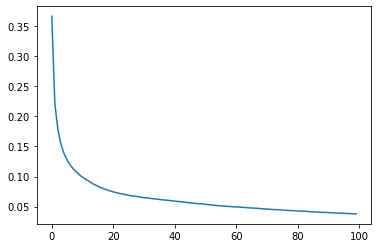

In [204]:
plt.plot(range(len(losslist)), losslist)

In [206]:
accuracy = 0
for idx, x in enumerate(testset):
    xi = x[0]
    yi = x[1]
    
    y_pred = model(xi)
    
    if yi.data  == round(y_pred.data):
        accuracy += 1
    if idx %  1== 0:
        print("y: {}, y_pred: {}".format(yi.data, round(y_pred.data)))
print("Accuracy: ", accuracy/len(testset))

y: 1, y_pred: 1
y: 1, y_pred: 1
y: 1, y_pred: 1
y: 1, y_pred: 1
y: 1, y_pred: 1
y: 0, y_pred: 0
y: 0, y_pred: 1
y: 1, y_pred: 1
y: 1, y_pred: 1
y: 0, y_pred: 0
y: 1, y_pred: 1
y: 0, y_pred: 0
y: 0, y_pred: 0
y: 0, y_pred: 0
y: 1, y_pred: 1
y: 0, y_pred: 1
y: 0, y_pred: 0
y: 1, y_pred: 1
y: 0, y_pred: 1
y: 1, y_pred: 1
y: 0, y_pred: 1
Accuracy:  0.8095238095238095


In [208]:
model.save("saved_models/sonar.pkl")

In [209]:
# now we load the weights and test it

val_model = nn.SimpleMLP(60, 1, [12])

# temporary fix to make last layer nonlin=False
for i, layer in enumerate(model.layers):
    if i == len(model.layers) - 1:
        for n in layer.neurons:
            n.nonlin = False
            
val_model.load_pkl("saved_models/sonar.pkl")

accuracy = 0
for idx, x in enumerate(testset):
    xi = x[0]
    yi = x[1]
    
    y_pred = model(xi)
    
    if yi.data  == round(y_pred.data):
        accuracy += 1
    if idx %  1== 0:
        print("y: {}, y_pred: {}".format(yi.data, round(y_pred.data)))
print("Accuracy: ", accuracy/len(testset))

y: 1, y_pred: 1
y: 1, y_pred: 1
y: 1, y_pred: 1
y: 1, y_pred: 1
y: 1, y_pred: 1
y: 0, y_pred: 0
y: 0, y_pred: 1
y: 1, y_pred: 1
y: 1, y_pred: 1
y: 0, y_pred: 0
y: 1, y_pred: 1
y: 0, y_pred: 0
y: 0, y_pred: 0
y: 0, y_pred: 0
y: 1, y_pred: 1
y: 0, y_pred: 1
y: 0, y_pred: 0
y: 1, y_pred: 1
y: 0, y_pred: 1
y: 1, y_pred: 1
y: 0, y_pred: 1
Accuracy:  0.8095238095238095
